# Basic Bot Detection using Luminol

### Set Up Environment

In [8]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Get Data

The dataset has 4 attributes: <br> <br>
**date**: yyyy-mm-dd (from 2006-07-01 through 2006-09-30) <br> <br>
**l_ipn**: local IP (coded as an integer from 0-9) <br> <br>
**r_asn**: remote ASN (an integer which identifies the remote ISP) <br> <br>
**f**: flows (count of connnections for that day) <br>

In [2]:
import pandas as pd
df = pd.read_csv('cs448b_ipasn.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20803 entries, 0 to 20802
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    20803 non-null  object
 1   l_ipn   20803 non-null  int64 
 2   r_asn   20803 non-null  int64 
 3   f       20803 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 650.2+ KB


In [4]:
#Missing or NAN values in dataset
df.isnull().sum()

date     0
l_ipn    0
r_asn    0
f        0
dtype: int64

In [5]:
#suspicious behavior
dic = {'2006-08-24':1,'2006-09-04':5,'2006-09-18':4,'2006-09-26':3,'2006-09-26':6}
marked_anomalies = pd.DataFrame.from_dict(dic,orient='index')
marked_anomalies.reset_index(inplace = True)
marked_anomalies.columns = ['date','l_ipn']
print(marked_anomalies)

         date  l_ipn
0  2006-08-24      1
1  2006-09-04      5
2  2006-09-18      4
3  2006-09-26      6


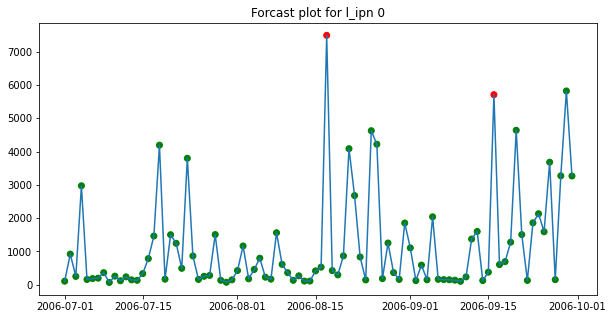

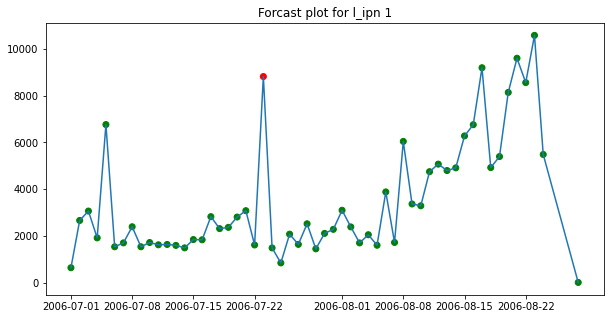

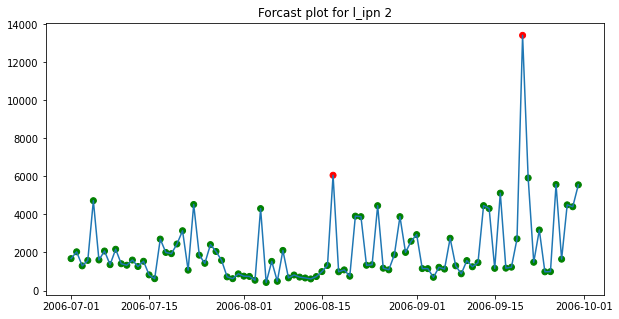

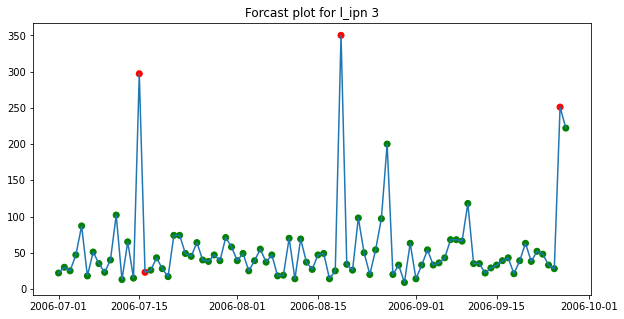

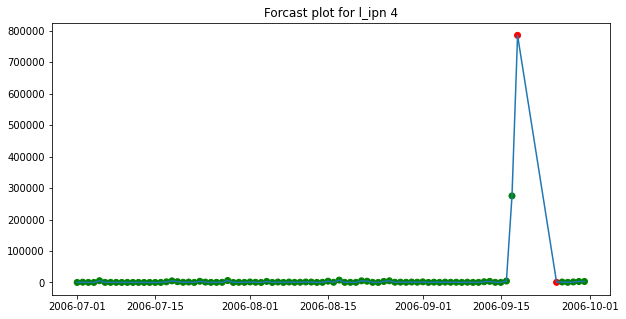

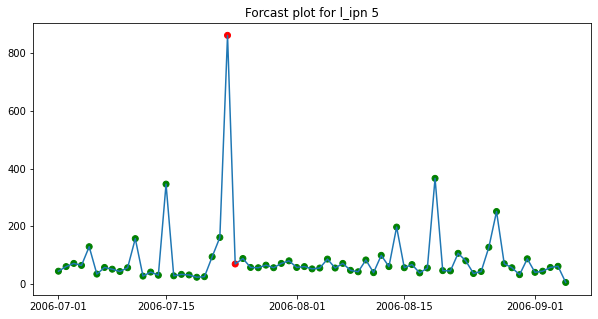

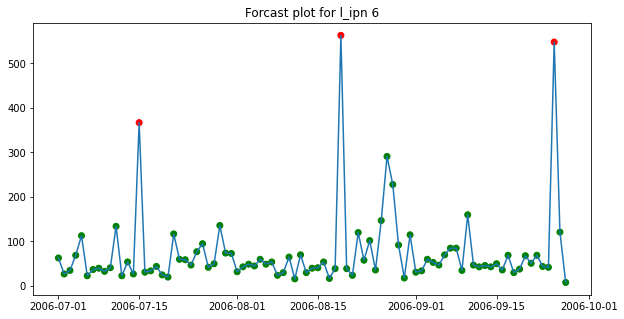

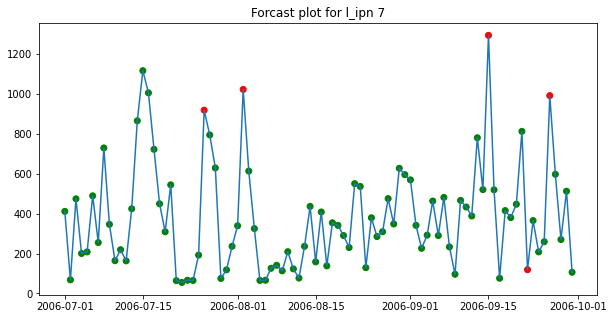

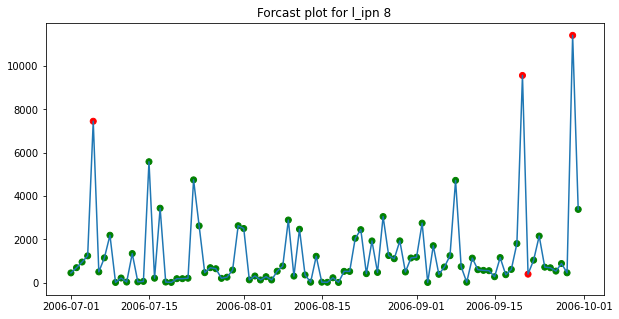

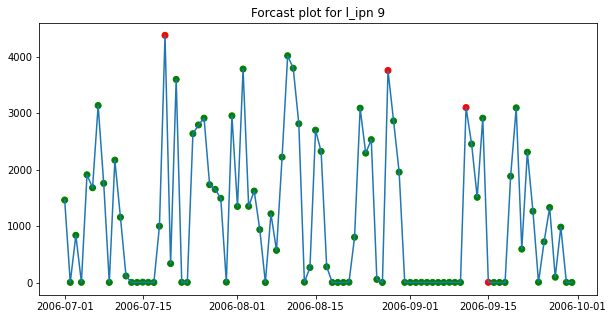

In [7]:
import luminol
from luminol.anomaly_detector import AnomalyDetector
from pandas import to_datetime

import numpy as np
import matplotlib.pyplot as plt

daily_aggregate_l_ipn = df.groupby(['l_ipn','date'])[['f']].sum()
daily_aggregate_l_ipn.reset_index(inplace= True)


def get_daily_aggregate_l_ipn(in_l_ipn):
    temp_df = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == in_l_ipn].drop(['l_ipn'],axis = 1)
    temp_df.columns = ['ds','y']
    temp_df['ds'] = to_datetime(temp_df['ds'])
    temp_df.reset_index(inplace=True,drop=True)
    return temp_df

def get_luminol_anomalies(in_df):
    in_df['isAnomaly'] = 0
    detector = AnomalyDetector(in_df['y'].to_dict())
    anomalies = detector.get_anomalies()
    time_period = ()
    for j in range(len(anomalies)):
        time_period = anomalies[j].get_time_window()
        for k in time_period:
            in_df.at[k,'isAnomaly'] = 1     
    return(in_df)    
for i in range(df['l_ipn'].nunique()):
    t_df = get_luminol_anomalies(get_daily_aggregate_l_ipn(i))
    
    colors = {0:'green', 1:'red'}
   
    plt.figure(figsize=(10,5))
    plt.plot(t_df['ds'],t_df['y'])
    plt.scatter(t_df['ds'],t_df['y'],c=t_df['isAnomaly'].apply(lambda x: colors[x]))
    plt.title('Forcast plot for l_ipn %d' %i)
    plt.show()
